In [16]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset
data_dir = 'data/'
images_folder = os.path.join(data_dir, 'images')
styles_path = os.path.join(data_dir, 'styles.csv')

# Read styles.csv for labels
df = pd.read_csv(styles_path)
df = df[df['id'].apply(lambda x: os.path.isfile(os.path.join(images_folder, str(x) + '.jpg')))]
df['image'] = df['id'].apply(lambda x: os.path.join(images_folder, str(x) + '.jpg'))

# Focus on the 'masterCategory' column
df = df[['image', 'masterCategory']]

# Count the number of samples in each category
category_counts = df['masterCategory'].value_counts()
print(category_counts)

# Filter categories with at least 2 samples
valid_categories = category_counts[category_counts >= 2].index

# Filter the dataframe to include only valid categories
df = df[df['masterCategory'].isin(valid_categories)]

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['masterCategory'], random_state=42)

# Data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image', y_col='masterCategory', target_size=(160, 160), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_df, x_col='image', y_col='masterCategory', target_size=(160, 160), batch_size=32, class_mode='categorical')

masterCategory
Apparel           21395
Accessories       11289
Footwear           9222
Personal Care      2404
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64
Found 35552 validated image filenames belonging to 6 classes.
Found 8888 validated image filenames belonging to 6 classes.


In [18]:
# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=5, validation_data=val_generator, verbose=1)

# Save the model
model.save('fashion_model.h5')

# Save model using .keras format
model.save('model.keras')

Epoch 1/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 360s 320ms/step - accuracy: 0.9121 - loss: 0.2781 - val_accuracy: 0.9732 - val_loss: 0.0961
Epoch 2/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 329s 296ms/step - accuracy: 0.9622 - loss: 0.1261 - val_accuracy: 0.9579 - val_loss: 0.1328
Epoch 3/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 273s 245ms/step - accuracy: 0.9669 - loss: 0.1142 - val_accuracy: 0.9698 - val_loss: 0.1003
Epoch 4/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 252s 226ms/step - accuracy: 0.9704 - loss: 0.1051 - val_accuracy: 0.9464 - val_loss: 0.1669
Epoch 5/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 282s 252ms/step - accuracy: 0.9708 - loss: 0.1001 - val_accuracy: 0.9602 - val_loss: 0.1312


278/278 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.9626 - loss: 0.1278
Validation Accuracy: 96.02%


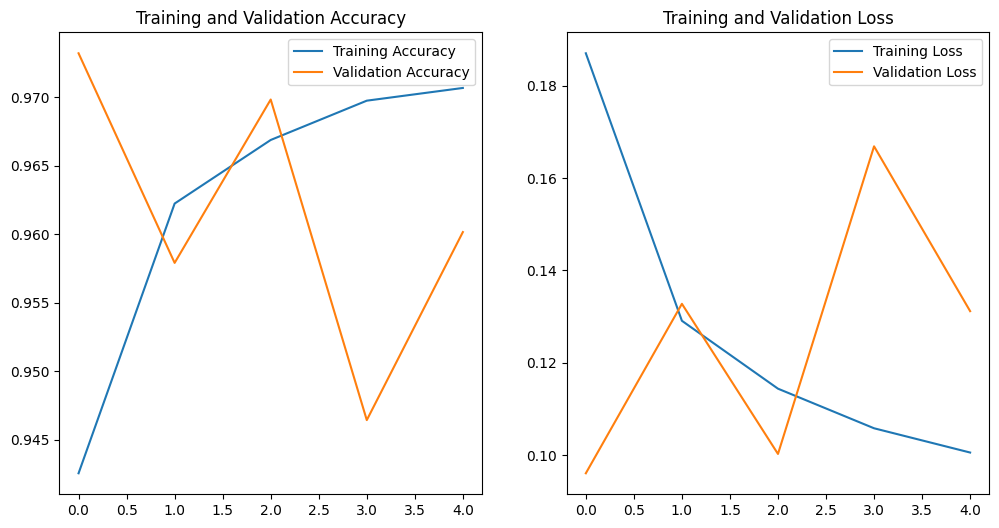

In [19]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.savefig('figures/training_history.png')
plt.show()



278/278 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step
                precision    recall  f1-score   support

   Accessories       0.26      0.29      0.28      2258
       Apparel       0.49      0.47      0.48      4279
      Footwear       0.21      0.21      0.21      1844
    Free Items       0.00      0.00      0.00        21
 Personal Care       0.05      0.05      0.05       481
Sporting Goods       0.00      0.00      0.00         5

      accuracy                           0.35      8888
     macro avg       0.17      0.17      0.17      8888
  weighted avg       0.35      0.35      0.35      8888



c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

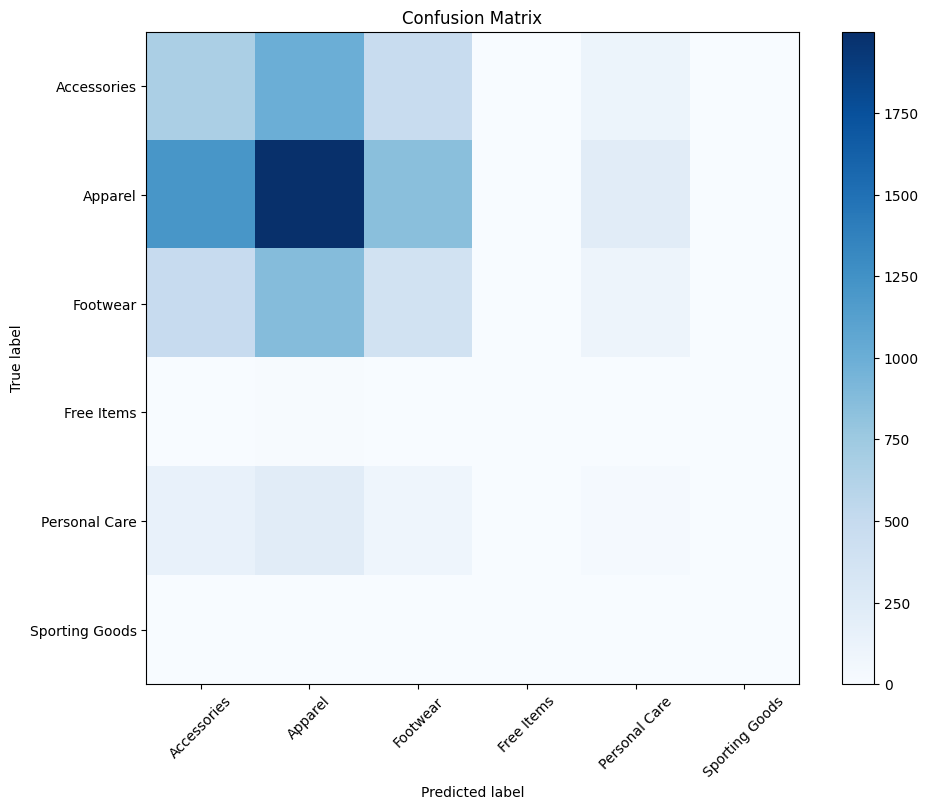

In [20]:
# Predictions and performance metrics
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('figures/confusion_matrix.png')
plt.show()